In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [59]:
### Plot full
experiments_df = pd.read_csv(os.path.join('data_sim', 'experiments_sim.txt'), sep=',', header=0)
display(experiments_df)

,expname,rollouts,tree,updatefreq,runs,obstacle,prunthreshold,u_bounded,inputvar,improved_version,threads,filterorder_and_window,done,refreshrate_meashured
0,1A,20,no,60.0,10,no,0,2.0,0.2,no,1,1_6,yes,200
1,1B,20,no,100.0,10,no,0,2.0,0.2,no,2,1_6,yes,200
2,2A,64,no,60.0,10,no,0,2.0,0.2,no,4,1_6,yes,200
3,2B,64,no,100.0,10,no,0,2.0,0.2,no,4,1_6,yes,100
4,3A,128,no,60.0,10,no,0,2.0,0.2,no,4,1_6,yes,200
5,3B,128,no,100.0,10,no,0,2.0,0.2,no,6,1_6,yes,130
6,11A,20,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,70
7,12A,26,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,55
8,13A,32,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,45
9,21B,20,no,100.0,10,yes,0,2.0,0.2,no,6,1_6,yes,150


In [60]:
# path_dict = {}
# for expname in experiments_df['expname']:
#     list_unified_file_paths = []
    
#     base_directory = os.path.join('data_sim', expname)
#     for filename in os.listdir(base_directory):
#         if filename.endswith("_unified.csv"): 
#             list_unified_file_paths.append(os.path.join(base_directory, filename))
#         else:
#             pass
        
#     list_unified_file_paths.sort()
#     path_dict[expname] = list_unified_file_paths
        
# #path_dict

In [147]:
class unifiles_handler():
    def __init__(self, obstacle_mode='both', exp_filter=['ALL']):
        self.sequences = 6
        
        self.obstacle_mode = obstacle_mode
        self.expname_filer_list = exp_filter
        self.unifiles_dict = {}
        
        self.columns_to_summarize = ['_resetted_time','cost','pos_x_REAL', '_eucledian_distance', 'min_rollout_cost', 'max_rollout_cost']
        
        self.experiment_df = self.get_experiment_config()
        
        for expname in self.experiment_df['expname']:
            self.unifiles_dict[expname] = {'data': {}, 'config': {}}
            
            self.unifiles_dict[expname]['data']['paths'] = self.get_paths(expname)
            self.unifiles_dict[expname]['data']['dfs'] = []
            
            for path in self.unifiles_dict[expname]['data']['paths']:
                temp_df = self.get_df(path)                
                temp_df = self.preprocess_df(temp_df)
                self.unifiles_dict[expname]['data']['dfs'].append(temp_df)
                
                
        # preprocessing summary dfs
        for expname in self.experiment_df['expname']: 
            self.gen_exp_summary(expname)
            self.gen_exp_metrics(expname)

        
    ## init helpers    
        
    def get_experiment_config(self):
        experiment_df = pd.read_csv(os.path.join('data_sim', 'experiments_sim.txt'), sep=',', header=0)
        
        experiment_df = experiment_df.loc[experiment_df['done']=='yes']
        
        if self.obstacle_mode == 'both':
            pass
        elif self.obstacle_mode == 'yes':
            experiment_df = experiment_df.loc[experiment_df['obstacle']=='yes']
        elif self.obstacle_mode == 'no':
            experiment_df = experiment_df.loc[experiment_df['obstacle']=='no']
        
        if 'ALL' in self.expname_filer_list:
            pass
        else:
            experiment_df = experiment_df.loc[experiment_df['expname'].isin(self.expname_filer_list)]
        
        
        display(experiment_df)
        
        return experiment_df
    
    
    def get_paths(self, expname):
        
        list_unified_file_paths = []
        
        base_directory = os.path.join('data_sim', expname)
        
        for filename in os.listdir(base_directory):
            if filename.endswith("_unified.csv"): 
                list_unified_file_paths.append(os.path.join(base_directory, filename))
            else:
                pass

        list_unified_file_paths.sort()
        
        return list_unified_file_paths
    
    
    def get_df(self, path):
        return pd.read_csv(path, header=0)
    
    
    ## preprocessing helpers
    
    def preprocess_df(self, df):
        
        # add resetted time
        df['_resetted_time'] = (df['time'] - df['time'].min())*1.0E-9
        
        
        return df
    
    
    def gen_exp_summary(self, expname):
        orig_df = self.unifiles_dict[expname]['data']['dfs'][0]
        
        init_df = pd.DataFrame(orig_df[['_resetted_time', 'pos_x_DESI', 'pos_y_DESI', 'pos_z_DESI']])
            
        # iterate over all dfs
        sum_df = init_df.copy()
        for df_idx in range(0, len(self.unifiles_dict[expname]['data']['paths'])):
            temp_df = self.unifiles_dict[expname]['data']['dfs'][df_idx]
            temp_df = temp_df[self.columns_to_summarize]
            
            sum_df = pd.merge_asof(sum_df, temp_df, on='_resetted_time', suffixes=('', '_'+str(df_idx)), direction='nearest')
        
        
        self.unifiles_dict[expname]['data_sum'] = sum_df
        
        
    def gen_exp_metrics(self, expname):
        sum_df = self.unifiles_dict[expname]['data_sum']
        
        metric_df = pd.DataFrame(sum_df[['_resetted_time','pos_x_DESI', 'pos_y_DESI', 'pos_z_DESI']])
        
        for column_name in self.columns_to_summarize[1:]:
            columns = []
            for df_idx in range(0, len(self.unifiles_dict[expname]['data']['paths'])):
                if df_idx==0:
                    column_name_adapted = column_name
                else:
                    column_name_adapted = column_name+'_'+str(df_idx)
                
                columns.append(column_name_adapted)
                
                
                
            metric_df[column_name+'_mean'] = sum_df[columns].mean(axis=1)
            metric_df[column_name+'_median'] = sum_df[columns].median(axis=1)
            metric_df[column_name+'_q1'] = sum_df[columns].quantile(q=0.25, axis=1)
            metric_df[column_name+'_q3'] = sum_df[columns].quantile(q=0.75, axis=1)
            
        
        self.unifiles_dict[expname]['data_metrics'] = metric_df        
        
    
    ## generate plots
    
    def simple_comparison_plot(self, avg_mode='mean', metric='cost'):
        
        if metric == 'cost':
            metric= 'cost_'
        elif metric == 'eucledian':
            metric = '_eucledian_distance_'
        elif metric =='min_rollout_cost':
            avg_mode = 'mean'
            metric ='min_rollout_cost_'
        elif metric =='max_rollout_cost':
            avg_mode = 'mean'
            metric ='max_rollout_cost_'
            
        else:
            raise ValueError('This metric mode is not supported!')
        
        fig1, f1_ax = plt.subplots(ncols=1, nrows=1, figsize=(15,10))
        
        for expname in self.unifiles_dict:
            df = self.unifiles_dict[expname]['data_metrics']
            f1_ax.plot(df['_resetted_time'], df[metric+avg_mode], label=expname)
            f1_ax.fill_between(df['_resetted_time'], df[metric+'q1'], df[metric+'q3'], alpha=0.2)
            f1_ax.set_yscale('log')
#             f1_ax.set_xlim([0,12])
            f1_ax.legend()
            
                
        plt.show()
        
        
    def sequence_comparison_plot(self, avg_mode='mean', metric='cost'):
        
        time_line_dict = {1:[5.03,9], 2:[13.12,17], 3:[21.20,25], 4:[29.28,33], 5:[37.36,41], 6:[45.44,49]}
        
        if metric == 'cost':
            metric= 'cost_'
        elif metric == 'eucledian':
            metric = '_eucledian_distance_'
        elif metric =='min_rollout_cost':
            metric ='min_rollout_cost_'
        elif metric =='max_rollout_cost':
            metric ='max_rollout_cost_'
            
        else:
            raise ValueError('This metric mode is not supported!')
        
        fig2, f2_ax = plt.subplots(ncols=len(time_line_dict), nrows=1, figsize=(16,4))
        
        for sequence in time_line_dict:
            for expname in self.unifiles_dict:
                df = self.unifiles_dict[expname]['data_metrics']
                f2_ax[sequence-1].plot(df['_resetted_time'], df[metric+avg_mode], label=expname)
                f2_ax[sequence-1].fill_between(df['_resetted_time'], df[metric+'q1'], df[metric+'q3'], alpha=0.2)
                f2_ax[sequence-1].set_yscale('log')
                f2_ax[sequence-1].set_xlim(time_line_dict[sequence])
                f2_ax[sequence-1].legend(loc='upper right')


        plt.show()
        
        
    
                
                
    
                
        
        
        
        

In [148]:
UniFileObject = unifiles_handler(obstacle_mode='yes', exp_filter=['21B', '22B', '23B', '31B'])

,expname,rollouts,tree,updatefreq,runs,obstacle,prunthreshold,u_bounded,inputvar,improved_version,threads,filterorder_and_window,done,refreshrate_meashured
9,21B,20,no,100.0,10,yes,0,2.0,0.2,no,6,1_6,yes,150
10,22B,64,no,100.0,10,yes,0,2.0,0.2,no,6,1_6,yes,120
12,31B,20,yes,0.0,10,yes,0,2.0,0.2,no,3,1_6,yes,70


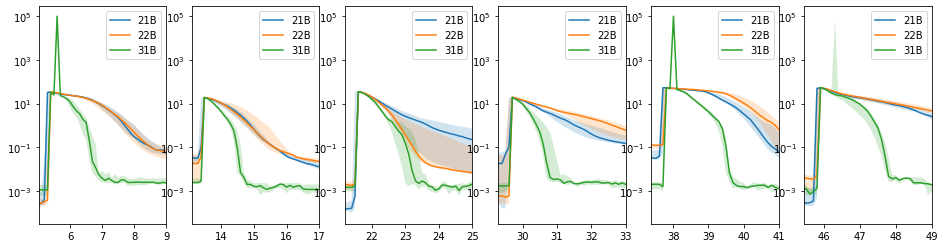

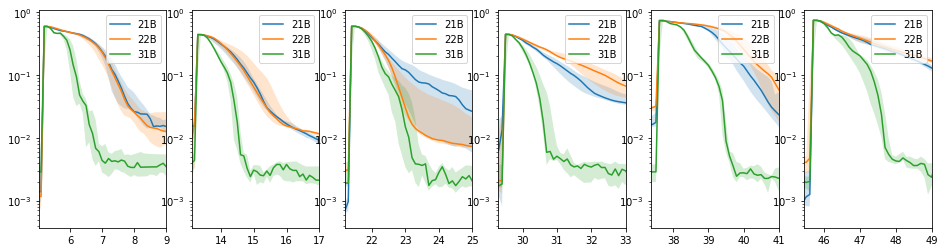

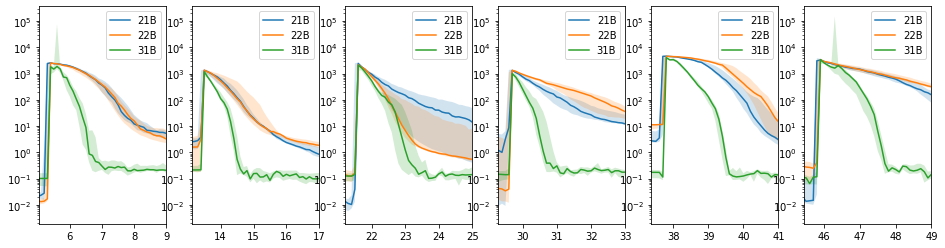

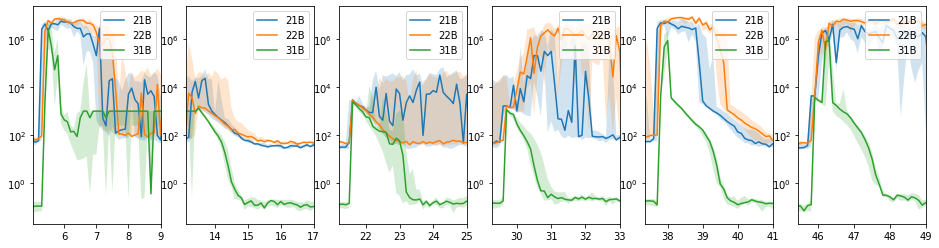

In [152]:
UniFileObject.sequence_comparison_plot(avg_mode='median', metric='cost')
UniFileObject.sequence_comparison_plot(avg_mode='median', metric='eucledian')
UniFileObject.sequence_comparison_plot(avg_mode='median', metric='min_rollout_cost')
UniFileObject.sequence_comparison_plot(avg_mode='median', metric='max_rollout_cost')

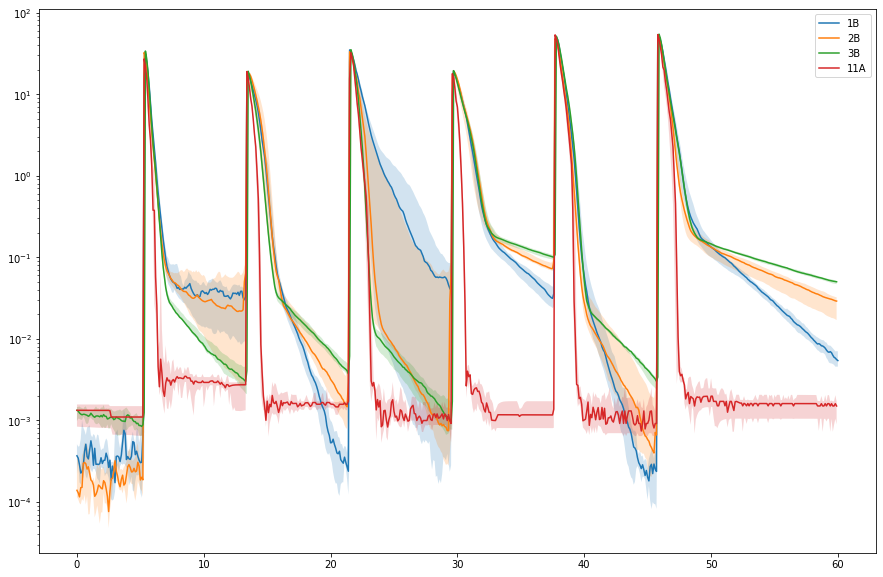

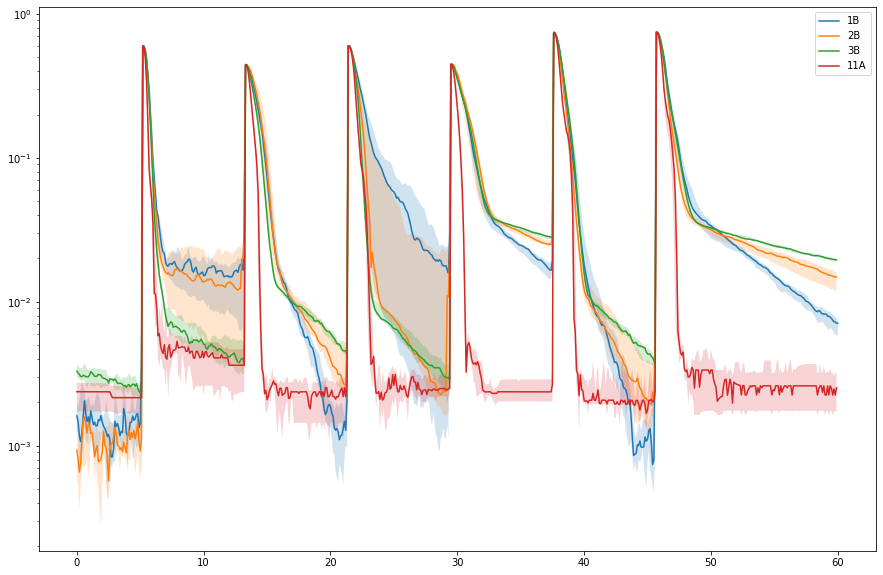

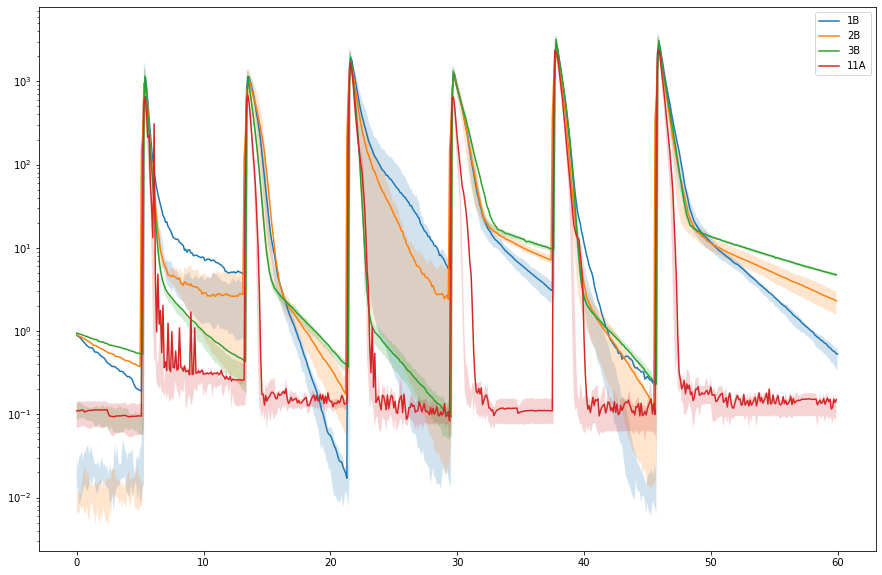

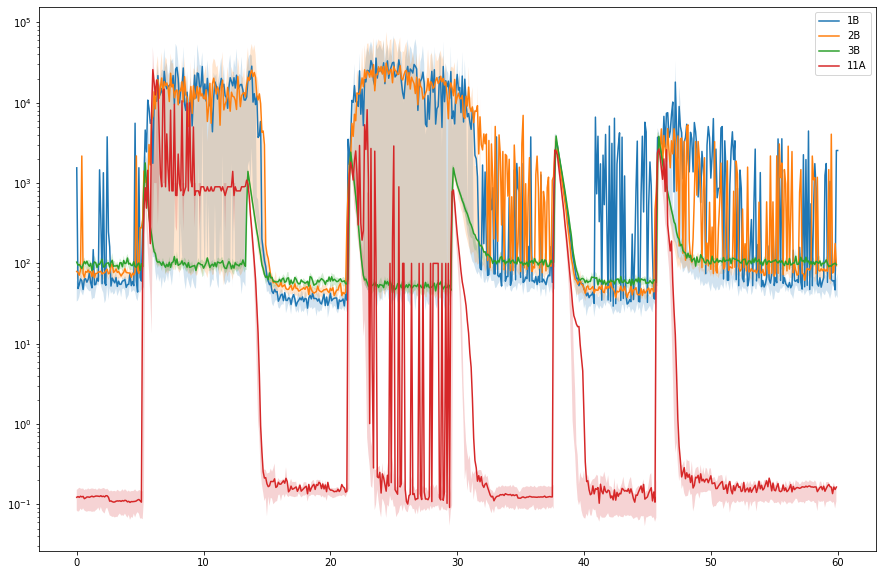

In [133]:
UniFileObject.simple_comparison_plot(avg_mode='median', metric='cost')
UniFileObject.simple_comparison_plot(avg_mode='median', metric='eucledian')
UniFileObject.simple_comparison_plot(metric='min_rollout_cost')
UniFileObject.simple_comparison_plot(metric='max_rollout_cost')